In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/DatasetWC'

Mounted at /content/gdrive
/content/gdrive/MyDrive/DatasetWC


# **Chuẩn bị dữ liệu**

In [ ]:
df =  pd.read_csv("results.csv")
df["date"] = pd.to_datetime(df["date"])

In [ ]:
#Đếm số lượng giá trị bị thiếu trong mỗi cột
df.isna().sum()

date           0
home_team      5
away_team      5
home_score    11
away_score    11
tournament     0
city           0
country        0
neutral        0
dtype: int64

In [ ]:
df.dropna(inplace=True)
df.dtypes

date          datetime64[ns]
home_team             object
away_team             object
home_score           float64
away_score           float64
tournament            object
city                  object
country               object
neutral                 bool
dtype: object

### Tập dữ liệu được sử dụng sẽ là Thế vận hội FIFA giữa năm 2018, từ sau World Cup 2018 đến các trận đấu cuối cùng trước World Cup 2022. Ý tưởng là chỉ phân tích các trận đấu diễn ra trong thời gian chuẩn bị và phân loại WC.

In [ ]:
df_filtered = df.loc[(df["date"].dt.year >= 2018) & (df["date"].dt.year <= 2022)]
print(df_filtered)

            date             home_team             away_team  home_score  \
41212 2018-01-02                  Iraq  United Arab Emirates         0.0   
41213 2018-01-02                  Oman               Bahrain         1.0   
41214 2018-01-05                  Oman  United Arab Emirates         0.0   
41215 2018-01-07               Estonia                Sweden         1.0   
41216 2018-01-11               Denmark                Sweden         0.0   
...          ...                   ...                   ...         ...   
45714 2022-12-30                  Iraq                Kuwait         1.0   
45715 2022-12-30                  Oman                 Syria         1.0   
45716 2022-12-30  United Arab Emirates               Lebanon         1.0   
45717 2022-12-30               Myanmar                  Laos         2.0   
45718 2022-12-30             Singapore               Vietnam         0.0   

       away_score        tournament         city               country  \
41212        

In [ ]:
df.home_team.value_counts()

home_team
Brazil               602
Argentina            590
Mexico               580
South Korea          543
Germany              542
                    ... 
Western Australia      1
Central Spain          1
Chechnya               1
Sark                   1
Hmong                  1
Name: count, Length: 327, dtype: int64

In [ ]:
rank = pd.read_csv("fifa_ranking-2024-04-04.csv")
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank[(rank["rank_date"] >= "2018-08-01") & (rank["rank_date"] <= "2022-12-31")].reset_index(drop=True)

*Điều chỉnh một vài tên nước*

Một số đội ở World Cup có tên khác nhau trong tập dữ liệu của bảng xếp hạng. Vì vậy, chúng em sẽ cần phải điều chỉnh.

In [ ]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

Việc hợp nhất được thực hiện để có được tập dữ liệu về các trận đấu thuộc khuôn khổ FIFA và thứ hạng của nó.

In [ ]:
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [ ]:
df_wc_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

In [ ]:
df_wc_ranked[(df_wc_ranked.home_team == "Brazil") | (df_wc_ranked.away_team == "Brazil")].tail(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
2904,2022-03-29,Bolivia,Brazil,0.0,4.0,FIFA World Cup qualification,La Paz,Bolivia,False,1308.12,1324.21,76.0,-1.0,1823.42,1826.35,2.0,0.0
2992,2022-06-02,South Korea,Brazil,1.0,5.0,Friendly,Seoul,South Korea,False,1519.54,1522.85,29.0,0.0,1832.69,1823.42,1.0,-1.0
3056,2022-06-06,Japan,Brazil,0.0,1.0,Friendly,Tokyo,Japan,False,1553.44,1549.82,23.0,0.0,1832.69,1823.42,1.0,-1.0
3257,2022-09-23,Brazil,Ghana,3.0,0.0,Friendly,Le Havre,France,True,1837.56,1837.56,1.0,0.0,1393.47,1389.68,60.0,0.0
3325,2022-09-27,Brazil,Tunisia,5.0,1.0,Friendly,Paris,France,True,1837.56,1837.56,1.0,0.0,1507.86,1507.86,30.0,0.0
3460,2022-11-24,Brazil,Serbia,2.0,0.0,FIFA World Cup,Lusail,Qatar,True,1841.30,1837.56,1.0,0.0,1563.62,1549.53,21.0,-4.0
3476,2022-11-28,Brazil,Switzerland,1.0,0.0,FIFA World Cup,Doha,Qatar,True,1841.30,1837.56,1.0,0.0,1635.92,1621.43,15.0,-1.0
3492,2022-12-02,Cameroon,Brazil,1.0,0.0,FIFA World Cup,Lusail,Qatar,True,1471.44,1484.95,43.0,5.0,1841.30,1837.56,1.0,0.0
3500,2022-12-05,Brazil,South Korea,4.0,1.0,FIFA World Cup,Doha,Qatar,True,1841.30,1837.56,1.0,0.0,1530.30,1526.02,28.0,0.0
3503,2022-12-09,Croatia,Brazil,1.0,1.0,FIFA World Cup,Al Rayyan,Qatar,True,1645.64,1632.15,12.0,-3.0,1841.30,1837.56,1.0,0.0


# **Tạo ra các đặc trưng**
1.   Điểm số của các trận đấu
2.  Số bàn thắng đã ghi và số bàn thua trước đó
3.   Các trận đấu đó có phải giao hữu hay không
4.   Xếp hạng của các đội
5.  Số bàn thắng ghi và số bàn thua trước các đội có xếp hạng cao hơn











In [ ]:
df = df_wc_ranked
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

In [ ]:
df[["result", "home_team_points", "away_team_points"]] = results

Điểm số của mỗi trận đấu là 3 cho kết quả thắng, 1 cho kết quả hòa và 0 cho kết quả thua và khác với điểm xếp hạng FIFA đã có trong cơ sở dữ liệu. Ngoài ra, người ta cho rằng điểm Xếp hạng FIFA và Xếp hạng FIFA của cùng một đội có mối tương quan nghịch và chúng ta chỉ nên sử dụng một trong số chúng để tạo ra các tính năng mới. Giả định này được kiểm tra dưới đây:


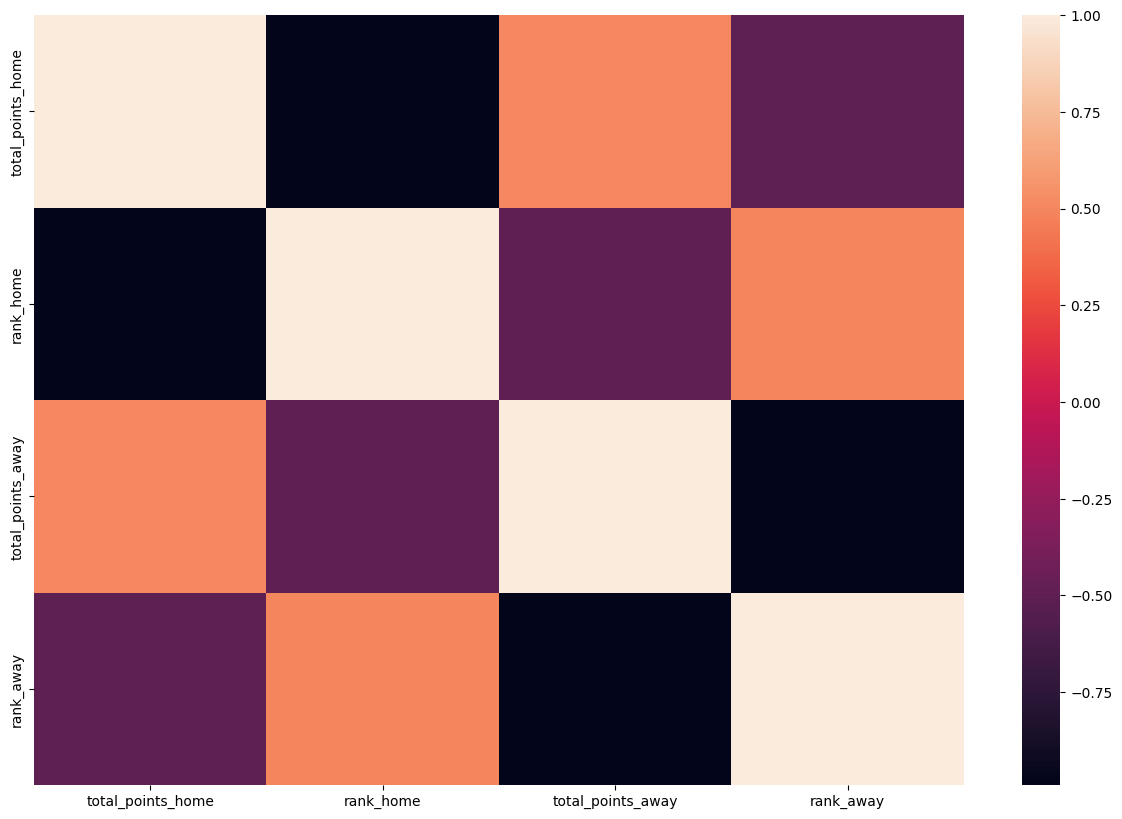

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr())
plt.show()

Bây giờ, chúng em tạo các cột sẽ giúp tạo ra các tính năng: chênh lệch thứ hạng, số điểm giành được trong trận đấu so với thứ hạng của đội phải đối mặt và hiệu số bàn thắng bại trong trò chơi. Tất cả những đặc điểm không có sự khác biệt nên được tạo ra cho hai đội (sân khách và sân nhà).

In [ ]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

Để tạo các tính năng, chúng em sẽ tách tập dữ liệu trong tập dữ liệu của đội chủ nhà và đội khách, thống nhất chúng và tính toán các giá trị trận đấu trong quá khứ. Sau đó, chúng em sẽ tách lại và hợp nhất chúng, lấy tập dữ liệu gốc. Quá trình này **tối ưu hóa** việc tạo ra các tính năng.

In [ ]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

In [ ]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

* Tạo ra một DataFrame mới*

In [ ]:
team_stats = pd.concat([home_team, away_team], ignore_index=True)

In [ ]:
#Tạo ra bản sao để sử dụng
team_stats_raw = team_stats.copy()



1.   Trung bình số bàn thắng của đội trong chu kỳ World Cup.
2.   Trung bình số bàn thắng của đội trong 5 trận đấu gần nhất.
3.   Trung bình số bàn thua của đội trong chu kỳ World Cup.
4.   Trung bình số bàn thua của đội trong 5 trận đấu gần nhất.
5.   Trung bình hạng FIFA của đội đối đầu trong chu kỳ World Cup.
6.   Trung bình hạng FIFA của đội đối đầu trong 5 trận đấu gần nhất.
7.   Điểm FIFA đã giành được trong chu kỳ.
8.   Điểm FIFA đã giành được trong 5 trận đấu gần nhất.
9.   Trung bình số điểm trong trận đấu trong chu kỳ.
10.   Trung bình số điểm trong trận đấu trong 5 trận đấu gần nhất.
11.   Trung bình số điểm dựa trên hạng đối đầu trong chu kỳ.
12.   Trung bình số điểm dựa trên hạng đối đầu trong 5 trận đấu gần nhất.











In [ ]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)

    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()

    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()

    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()

    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1]
    else:
        points = 0
        points_l5 = 0

    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()

    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()

    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [ ]:
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [ ]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [ ]:
home_team_stats.columns[-12:]

Index(['goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5'],
      dtype='object')

In [ ]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

In [ ]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

Để thống nhất cơ sở dữ liệu, cần thêm hậu tố nhà và sân khách cho mỗi cột. Sau đó, dữ liệu đã sẵn sàng để được hợp nhất.

In [ ]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [ ]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [ ]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

Bây giờ, để định lượng tầm quan trọng của trò chơi, một cột tìm kiếm sự cạnh tranh của trò chơi sẽ được tạo ra.

In [ ]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x))

In [ ]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [ ]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

Và sau đó, chúng em chỉ chọn các cột sẽ giúp phân tích "**tính** **năng**"

In [ ]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

base_df.tail()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
3514,2022-12-17,Singapore,Maldives,160.0,154.0,3.0,1.0,0,6.0,1.0,...,1.352941,0.8,0.009485,0.005870,1.148148,1.2,0.006725,0.006206,False,True
3515,2022-12-18,Argentina,France,3.0,4.0,3.0,3.0,2,-1.0,0.0,...,2.232143,2.6,0.136649,0.160020,2.166667,2.4,0.175278,0.230350,True,False
3516,2022-12-20,Cambodia,Philippines,177.0,133.0,3.0,2.0,0,44.0,3.0,...,0.806452,0.2,0.004258,0.001333,0.965517,0.8,0.006332,0.004550,True,False
3517,2022-12-21,Myanmar,Malaysia,158.0,146.0,0.0,1.0,1,12.0,0.0,...,0.629630,0.2,0.004132,0.001361,1.790698,2.2,0.011828,0.014114,True,False
3518,2022-12-21,Laos,Vietnam,187.0,96.0,0.0,6.0,1,91.0,4.0,...,0.500000,0.6,0.002589,0.003261,1.674419,2.6,0.013543,0.026750,True,False


In [ ]:
base_df.isna().sum()

date                              0
home_team                         0
away_team                         0
rank_home                         0
rank_away                         0
home_score                        0
away_score                        0
result                            0
rank_dif                          0
rank_change_home                  0
rank_change_away                  0
home_goals_mean                  99
home_goals_mean_l5               99
home_goals_suf_mean              99
home_goals_suf_mean_l5           99
home_rank_mean                   99
home_rank_mean_l5                99
home_points_mean                  0
home_points_mean_l5               0
away_goals_mean                  97
away_goals_mean_l5               97
away_goals_suf_mean              97
away_goals_suf_mean_l5           97
away_rank_mean                   97
away_rank_mean_l5                97
away_points_mean                  0
away_points_mean_l5               0
home_game_points_mean       

## Các trận đấu có **NaN** là những trận đấu không có dữ liệu. Những thứ đó sẽ bị bỏ đi.

In [ ]:
base_df_no_fg = base_df.dropna()

# **Phân tích dữ liệu**
### Bây giờ, chúng ta cần phân tích tất cả các tính năng đã được tạo và kiểm tra xem chúng có khả năng dự đoán hay không. Ngoài ra, nếu họ không có, chúng ta cần tạo ra một số thứ có, chẳng hạn như sự khác biệt giữa đội nhà và đội khách. Để phân tích khả năng dự đoán, tôi sẽ coi các trận hòa là trận thua của đội chủ nhà và sẽ tạo ra một bài toán nhị phân.

In [ ]:
df = base_df_no_fg

In [ ]:
df = base_df_no_fg.copy()
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x

df["target"] = df["result"].apply(no_draw)
df.head()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1,target
4,2018-08-26,Barbados,Cuba,160.0,181.0,0.0,0.0,2,-21.0,0.0,...,1.0,0.018519,0.018519,0.0,0.0,0.000000,0.000000,False,True,1
6,2018-08-29,Barbados,Cuba,160.0,181.0,0.0,2.0,1,-21.0,0.0,...,1.0,0.012022,0.012022,0.5,0.5,0.003125,0.003125,False,True,1
31,2018-09-06,Mongolia,Guam,186.0,190.0,1.0,1.0,2,-4.0,0.0,...,3.0,0.016216,0.016216,0.0,0.0,0.000000,0.000000,True,False,1
32,2018-09-06,Nepal,Bhutan,161.0,183.0,4.0,0.0,0,-22.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,True,False,0
33,2018-09-06,Bangladesh,Pakistan,194.0,201.0,1.0,0.0,0,-7.0,0.0,...,1.5,0.008197,0.008197,3.0,3.0,0.018634,0.018634,True,False,0


## ** Phân tích sẽ được thực hiện:**

## Violin và boxplot để phân tích xem các tính năng có phân bố khác nhau tùy theo mục tiêu hay không
# Biểu đồ phân tán để phân tích mối tương quan

In [ ]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

In [ ]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

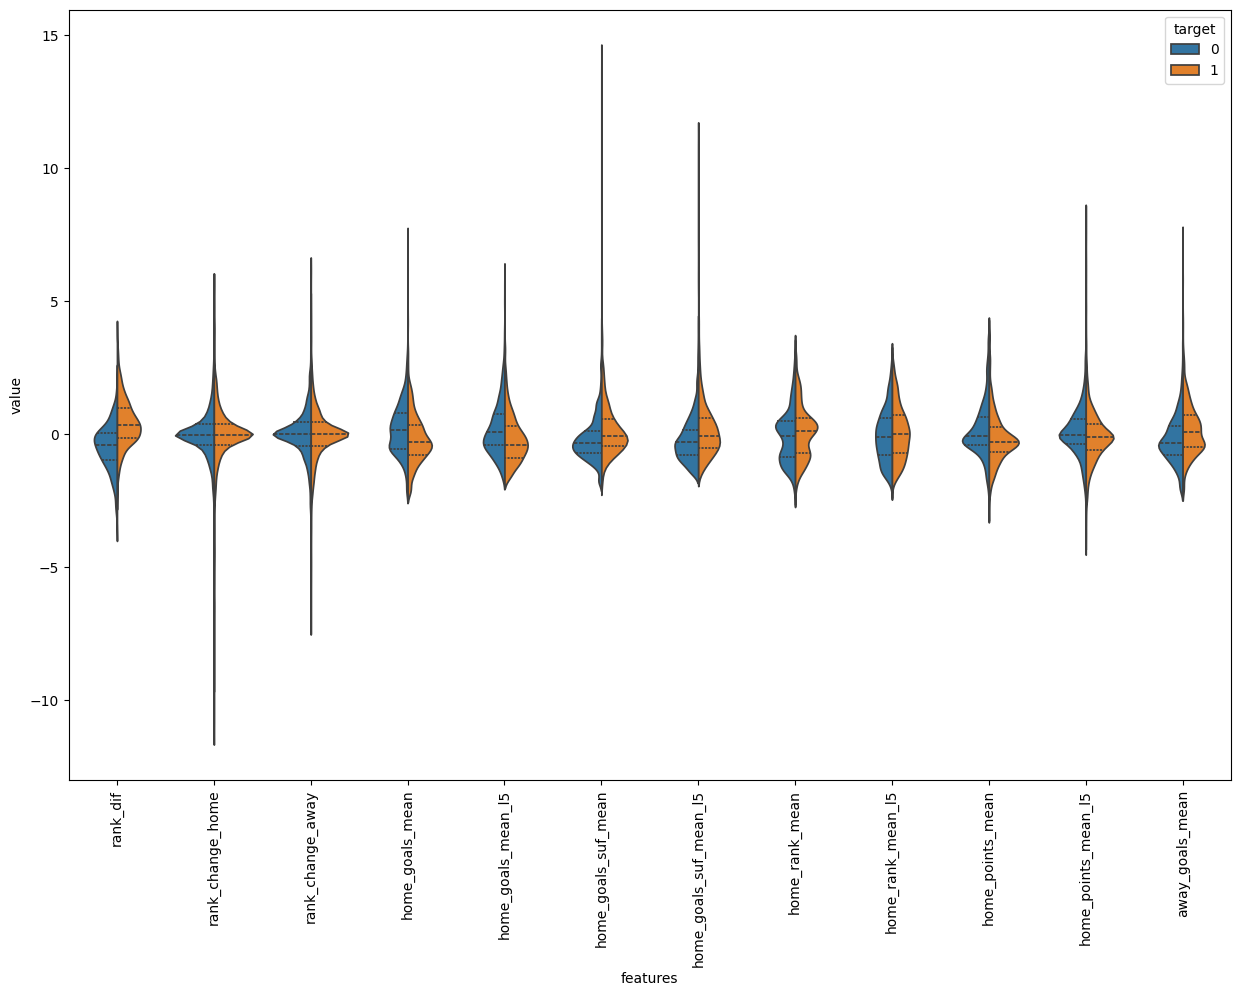

In [ ]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

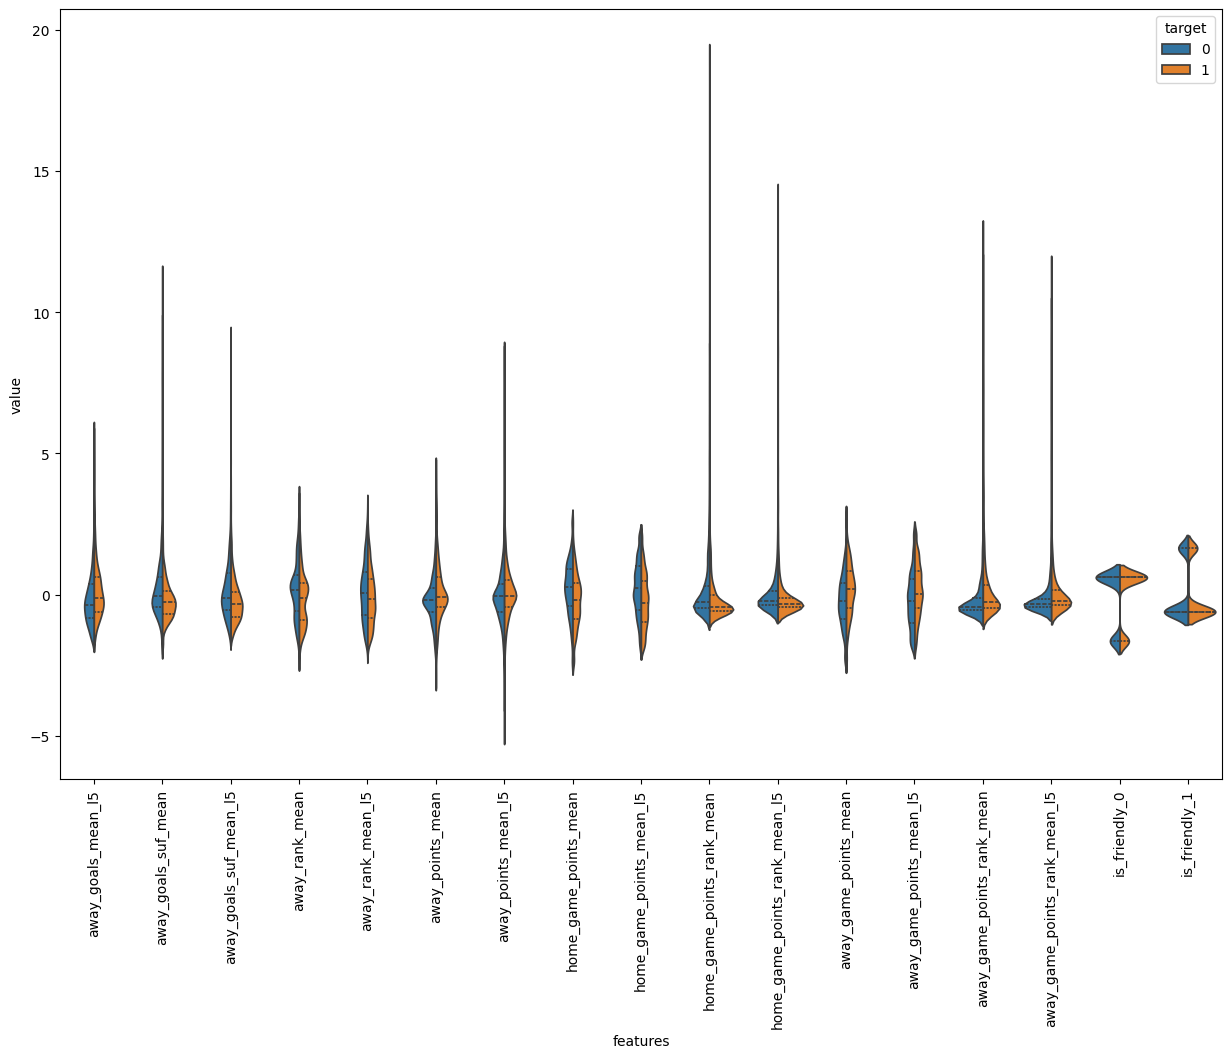

In [ ]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

## Với các biểu đồ, chúng em thấy rằng sự khác biệt về thứ hạng là dấu hiệu phân tách dữ liệu tốt duy nhất. Tuy nhiên, chúng em có thể tạo các tính năng giúp phân biệt sự khác biệt giữa đội nhà và đội khách và phân tích xem liệu chúng có phân tách dữ liệu tốt hay không.

In [ ]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

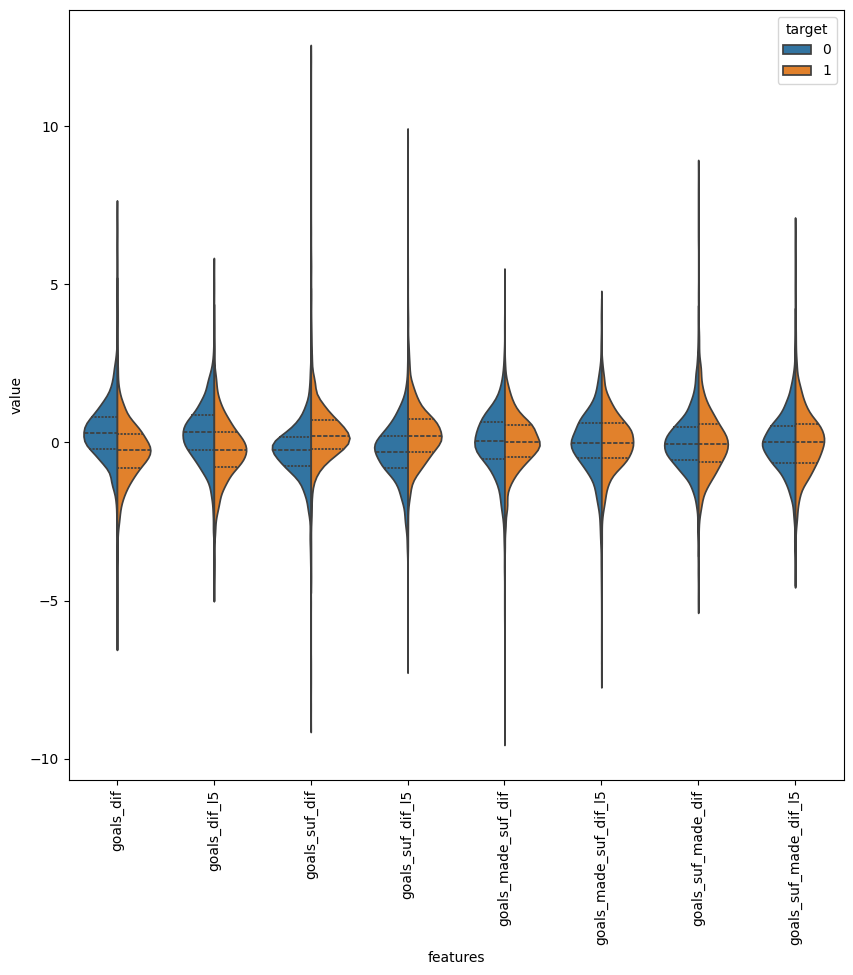

In [ ]:
data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Với biểu đồ đó, chúng ta thấy rằng hiệu số bàn thắng bại là sự phân tách tốt và số bàn thắng cũng chịu sự chênh lệch. Sự khác biệt giữa bàn thắng được ghi và bàn thua của các đội không phải là dấu hiệu phân biệt rõ ràng.

Bây giờ, chúng em có 5 tính năng:

rank_dif
goal_dif
goal_dif_l5
goal_suf_dif
goal_suf_dif_l5
Chúng em có thể tạo ra các tính năng khác, như sự khác biệt về điểm được tạo ra, sự khác biệt về điểm được tạo ra theo thứ hạng phải đối mặt và sự khác biệt về thứ hạng phải đối mặt.

In [ ]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]

In [ ]:
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

Ngoài ra, chúng em có thể tính toán các mục tiêu đạt được và đạt được theo cấp bậc, đồng thời kiểm tra sự khác biệt này.

In [ ]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

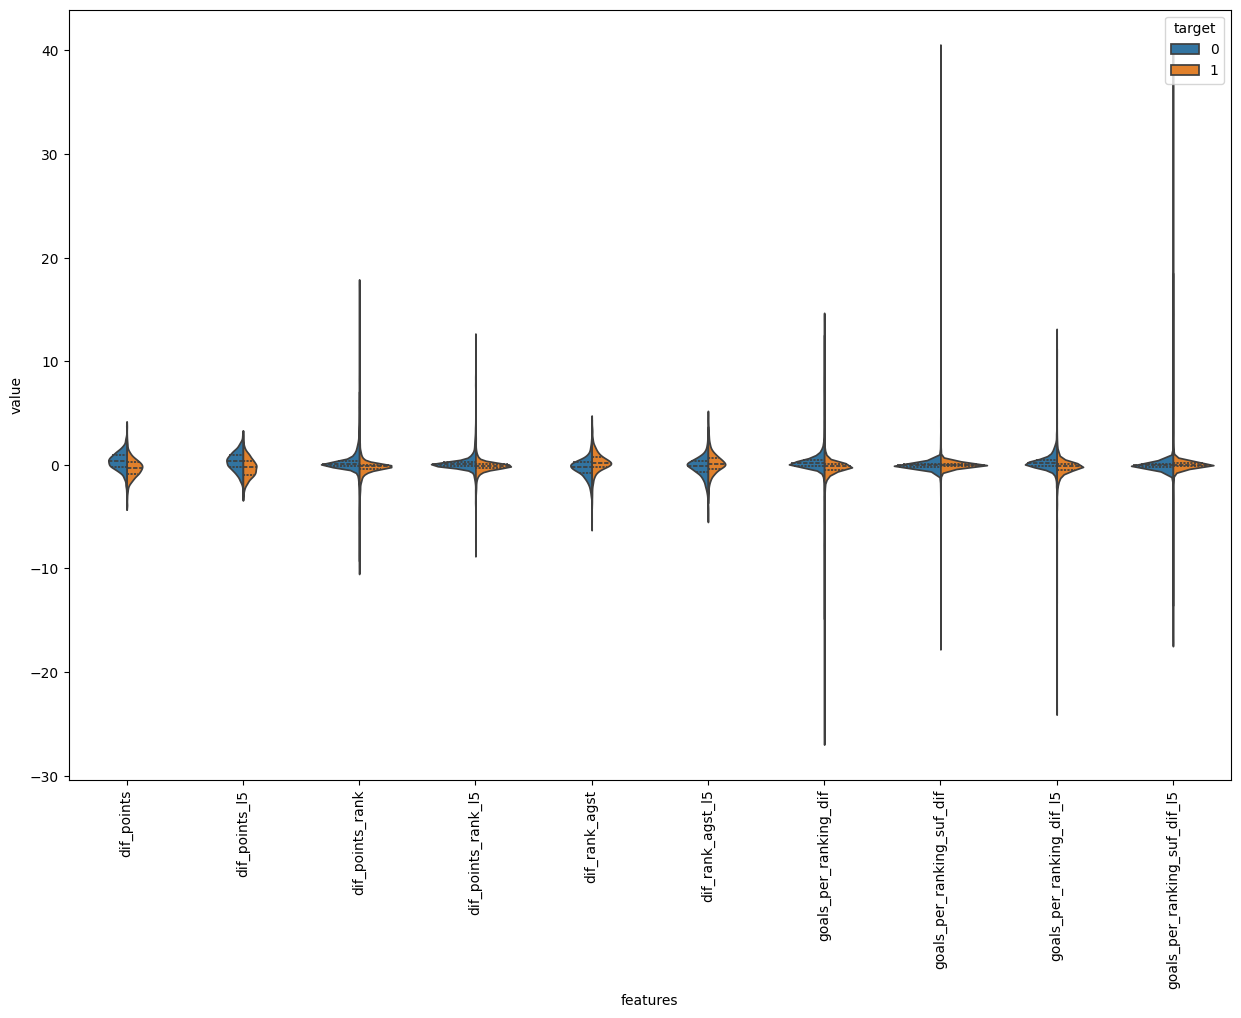

In [ ]:
data_difs = dif.iloc[:, -10:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

## Do các giá trị thấp, biểu đồ violin không phải là lựa chọn tốt để phân tích xem các đặc điểm có thực sự tách biệt dữ liệu trong trường hợp này hay không. Sau đó chúng ta sẽ thấy boxplot:

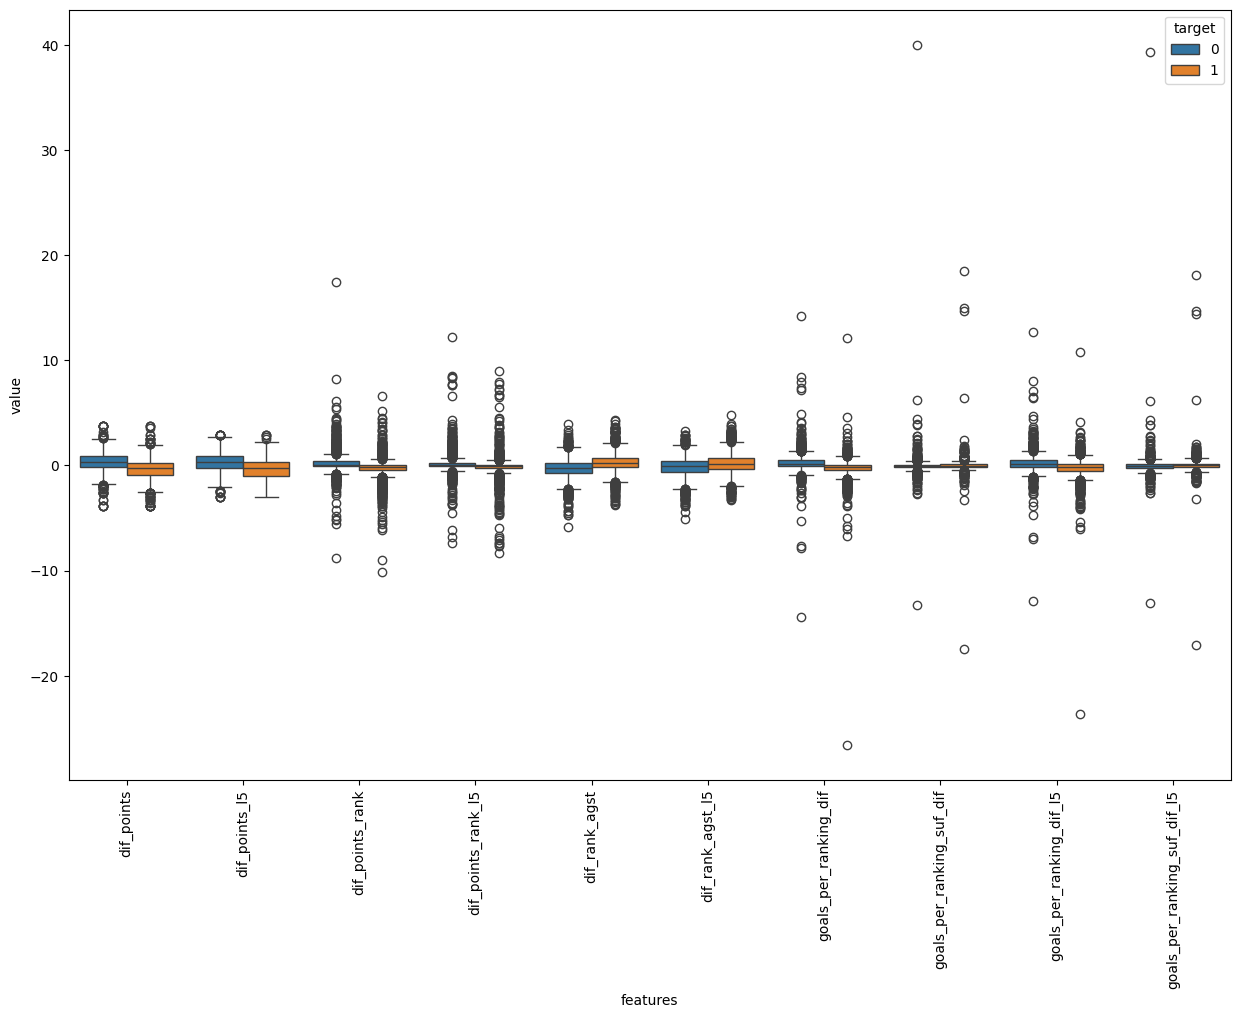

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()

## Chênh lệch điểm (toàn bộ và 5 trận gần nhất), chênh lệch điểm theo thứ hạng đối mặt (toàn bộ và 5 trận cuối cùng) và chênh lệch thứ hạng đối mặt (toàn bộ và 5 trận cuối cùng) là những tính năng hay. Ngoài ra, một số tính năng được tạo có phân phối rất giống nhau sẽ được phân tích bằng biểu đồ phân tán.

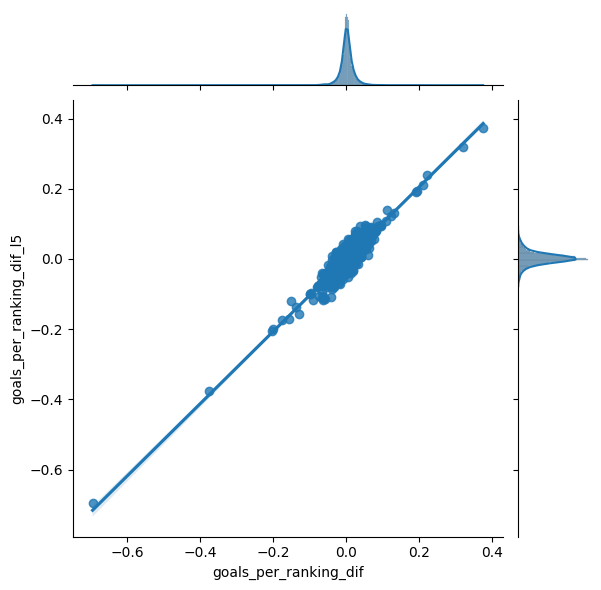

In [ ]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l5', kind="reg")
plt.show()

## Hiệu số bàn thắng bại theo thứ hạng phải đối mặt và phiên bản 5 trận gần đây nhất của nó có sự phân bổ rất giống nhau. Vì vậy, chúng tôi sẽ chỉ sử dụng phiên bản đầy đủ (goals_per_ranking_dif).

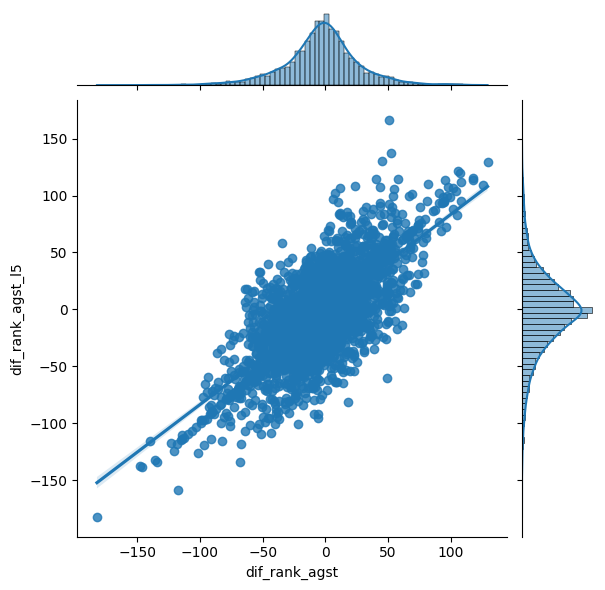

In [ ]:
sns.jointplot(data = data_difs, x = 'dif_rank_agst', y = 'dif_rank_agst_l5', kind="reg")
plt.show()

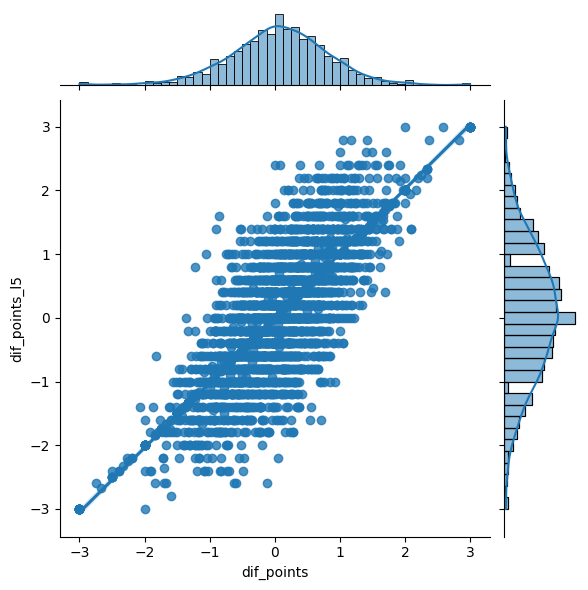

In [ ]:
sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l5', kind="reg")
plt.show()

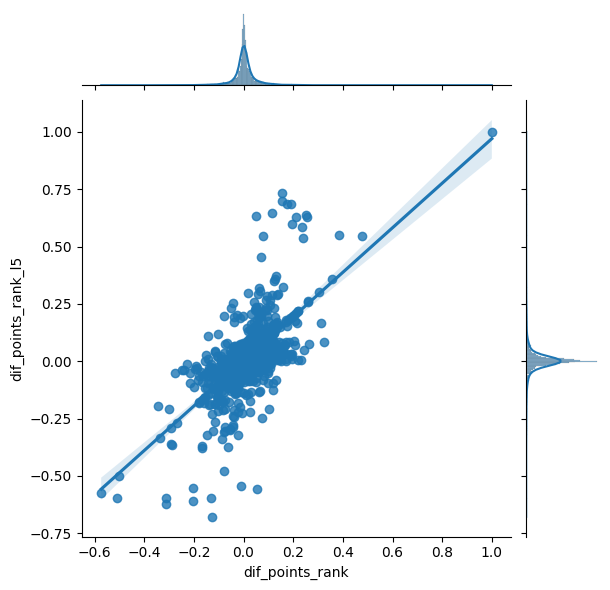

In [ ]:
sns.jointplot(data = data_difs, x = 'dif_points_rank', y = 'dif_points_rank_l5', kind="reg")
plt.show()

Về sự khác biệt về thứ hạng phải đối mặt, điểm trò chơi theo thứ hạng phải đối mặt và điểm trò chơi trung bình theo thứ hạng phải đối mặt, hai phiên bản (đầy đủ và 5 trò chơi) không quá giống nhau. Vì vậy, chúng tôi sẽ sử dụng cả hai.

Trên cơ sở đó, các tính năng cuối cùng là

*   rank_dif
*   goals_dif
*   goals_dif_l5
*   goals_suf_dif
*   goals_suf_dif_l5
*   dif_rank_agst
*   dif_rank_agst_l5
*   goals_per_ranking_dif
*   dif_points_rank
*   dif_points_rank_l5
*   is_friendly




In [ ]:
def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]

    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]

    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

In [ ]:
model_db = create_db(df)

In [ ]:
model_db

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
4,Barbados,Cuba,1,-21.0,2.000000,2.0,1.000000,1.0,0.037037,-92.000000,-92.0,0.018519,0.018519,False,True
6,Barbados,Cuba,1,-21.0,1.000000,1.0,0.500000,0.5,0.008511,-35.500000,-35.5,0.008897,0.008897,False,True
31,Mongolia,Guam,1,-4.0,4.000000,4.0,-1.000000,-1.0,0.021622,0.000000,0.0,0.016216,0.016216,True,False
32,Nepal,Bhutan,0,-22.0,1.000000,1.0,0.000000,0.0,0.004975,7.000000,7.0,0.000000,0.000000,True,False
33,Bangladesh,Pakistan,0,-7.0,-1.000000,-1.0,-0.500000,-0.5,-0.007200,30.500000,30.5,-0.010437,-0.010437,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514,Singapore,Maldives,0,6.0,0.382353,0.6,-0.175381,-0.2,0.004036,-19.851852,-23.0,0.002761,-0.000335,False,True
3515,Argentina,France,1,-1.0,-0.109788,0.4,-0.243386,-0.2,0.003482,-4.658069,0.8,-0.038629,-0.070329,True,False
3516,Cambodia,Philippines,0,44.0,-0.096774,0.2,1.286986,1.0,-0.001833,21.453838,9.4,-0.002074,-0.003217,True,False
3517,Myanmar,Malaysia,1,12.0,-1.138674,-2.0,1.679587,3.2,-0.008112,-6.173988,-12.4,-0.007696,-0.012754,True,False


# **The model**
Bây giờ chúng ta đã có cơ sở dữ liệu sẵn sàng và với các cột có khả năng dự đoán, chúng ta có thể bắt đầu lập mô hình.

Hai mô hình sẽ được thử nghiệm: Random Forest and Gradient Boosting.

In [ ]:
X = model_db.iloc[:, 3:]
y = model_db[["target"]]

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [ ]:
gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]
         }

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)

gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [ ]:
gb = gb_cv.best_estimator_

In [ ]:
gb

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=5,
                           random_state=5)

In [ ]:
params_rf = {"max_depth": [20],
                "min_samples_split": [10],
                "max_leaf_nodes": [175],
                "min_samples_leaf": [5],
                "n_estimators": [250],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [250]},
             verbose=False)

In [ ]:
rf = rf_cv.best_estimator_

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [ ]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()

    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

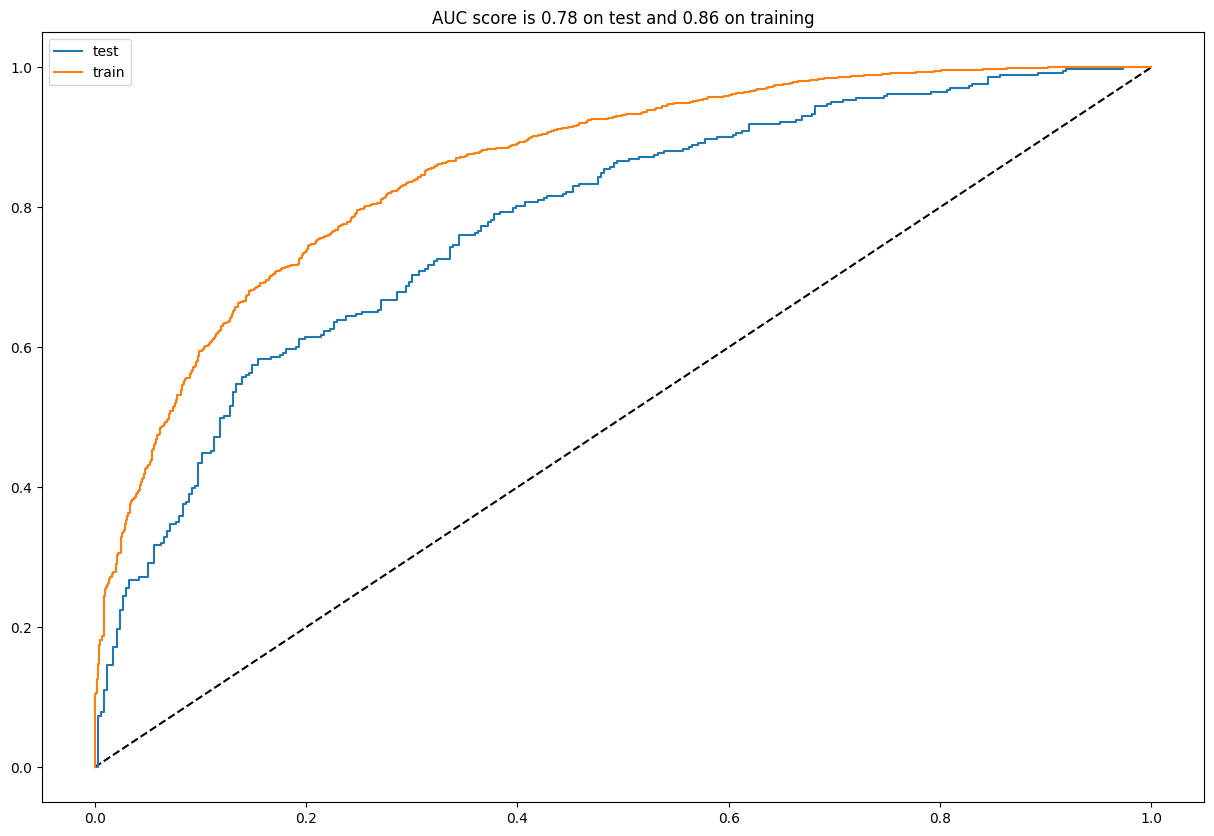

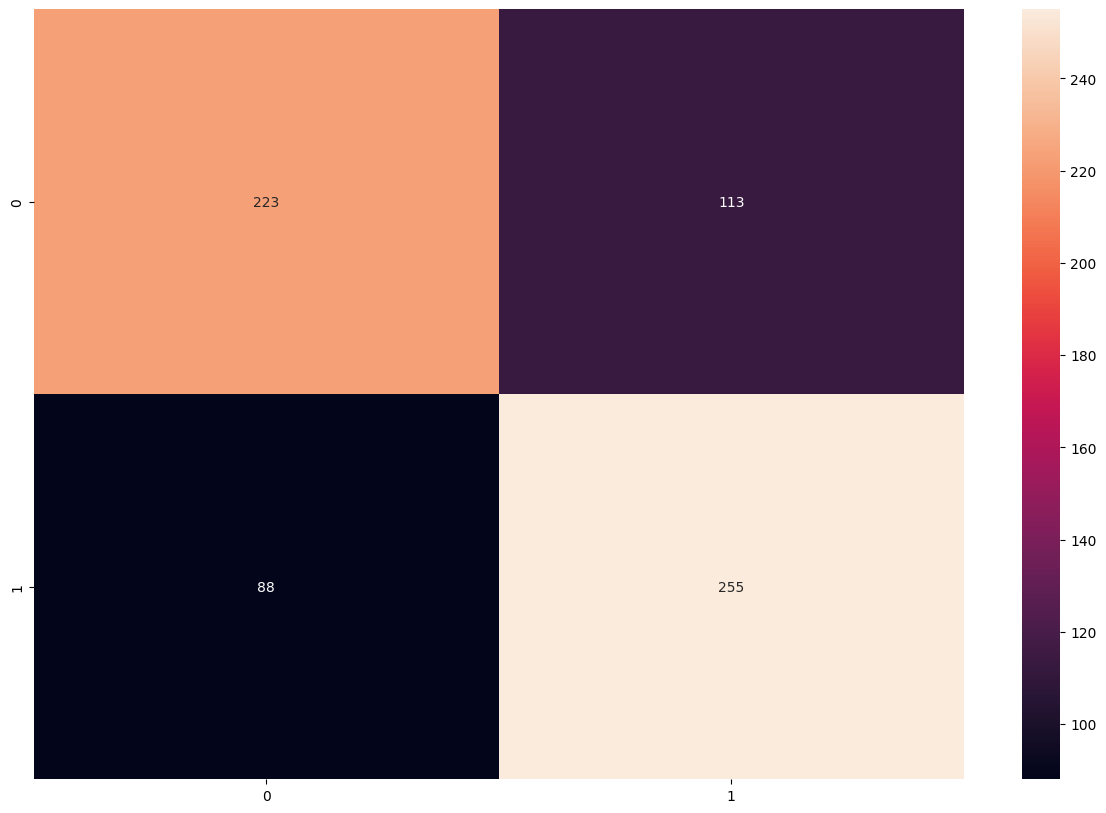

In [ ]:
analyze(gb)

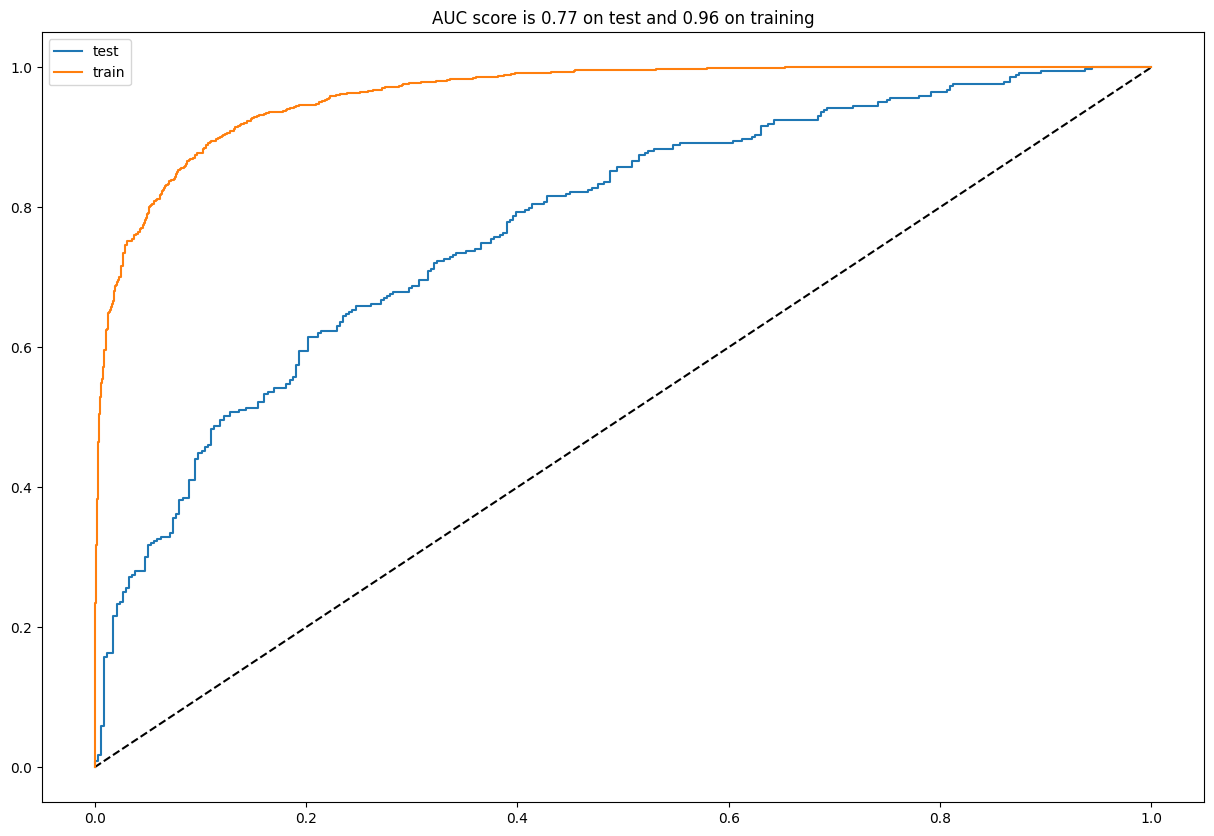

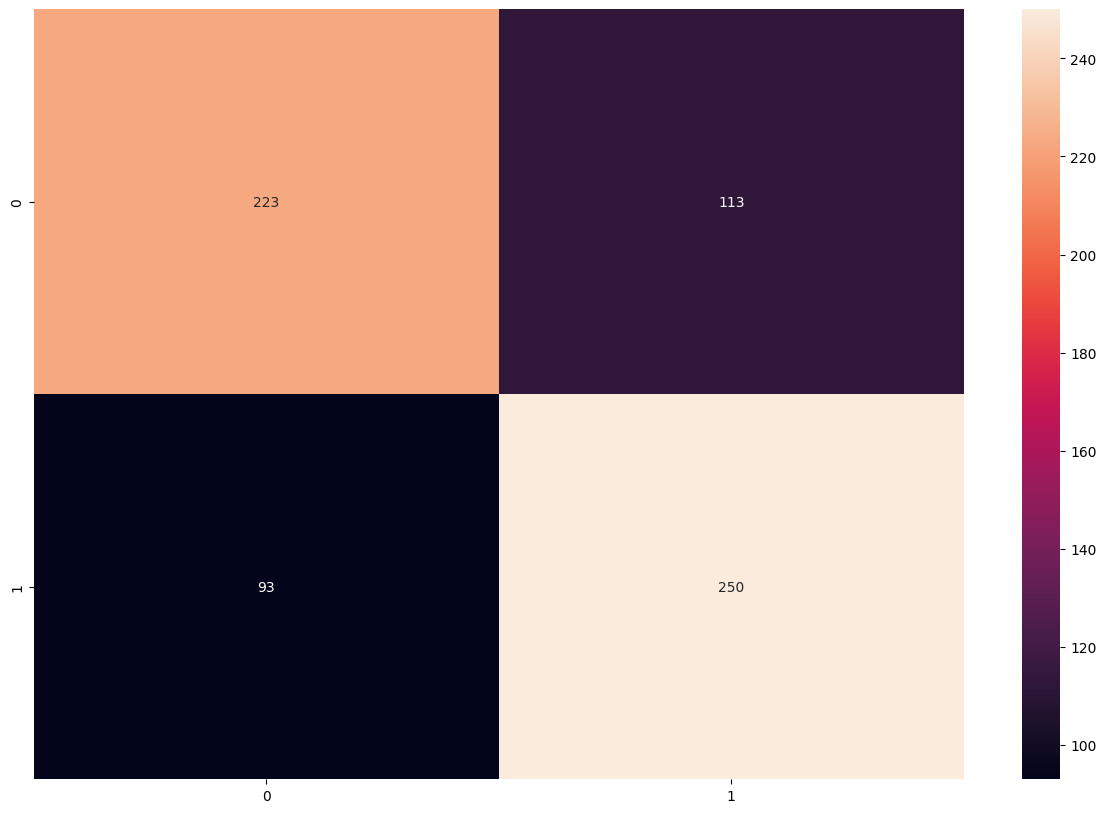

In [ ]:
analyze(rf)

The Random Forest Model tốt hơn một chút nhưng có vẻ không phù hợp. Vì vậy, chúng tôi sẽ sử dụng Gradient Boosting Model.

# **Mô Phỏng World Cup**
Việc đầu tiên là tạo ra các trận đấu FIFA World Cup. Để làm điều này, chúng em sẽ đưa vào wikipedia các trận đấu của các đội và vòng bảng.

In [ ]:
from operator import itemgetter

In [ ]:
dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")

In [ ]:
from collections.abc import Iterable
start_pos = 0
end_pos = len(dfs)
for i in range(len(dfs)):
    df = dfs[i]
    cols = list(df.columns.values)

    if isinstance(cols[0], Iterable):
        if any("Tie-breaking criteria" in c for c in cols):
            start_pos = i+1

        if any("Match 46" in c for c in cols):
            end_pos = i+1

In [ ]:
matches = []
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
group_count = 0

table = {}
#Bảng -> ĐỘi, ĐIỂM, XÁC SUẤT THẮNG (TIÊU CHÍ XẾP HẠNG)
table[groups[group_count]] = [[a.split(" ")[0], 0, []] for a in list(dfs[start_pos].iloc[:, 1].values)]

for i in range(start_pos+1, end_pos, 1):
    if group_count < len(groups):
        if len(dfs[i].columns) == 3:
            team_1 = dfs[i].columns.values[0]
            team_2 = dfs[i].columns.values[-1]

            matches.append((groups[group_count], team_1, team_2))
        else:
            group_count+=1
            if group_count < len(groups):
                table[groups[group_count]] = [[a, 0, []] for a in list(dfs[i].iloc[:, 1].values)]
    else:
        break

In [ ]:
table

{'A': [['Netherlands', 0, []],
  ['Senegal', 0, []],
  ['Ecuador', 0, []],
  ['Qatar', 0, []]],
 'B': [['England', 0, []],
  ['United States', 0, []],
  ['Iran', 0, []],
  ['Wales', 0, []]],
 'C': [['Argentina', 0, []],
  ['Poland', 0, []],
  ['Mexico', 0, []],
  ['Saudi Arabia', 0, []]],
 'D': [['France', 0, []],
  ['Australia', 0, []],
  ['Tunisia', 0, []],
  ['Denmark', 0, []]],
 'E': [['Japan', 0, []],
  ['Spain', 0, []],
  ['Germany', 0, []],
  ['Costa Rica', 0, []]],
 'F': [['Morocco', 0, []],
  ['Croatia', 0, []],
  ['Belgium', 0, []],
  ['Canada', 0, []]],
 'G': [['Brazil', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []],
  ['Serbia', 0, []]],
 'H': [['Portugal', 0, []],
  ['South Korea', 0, []],
  ['Uruguay', 0, []],
  ['Ghana', 0, []]]}

Ở trên, chúng em cũng lưu trữ điểm của đội tại nhóm và xác suất giành chiến thắng trong mỗi trận đấu. Xác suất thắng trung bình của các đội sẽ được dùng làm tiebreak khi hai đội có cùng số điểm.

In [ ]:
matches[:10]

[('A', 'Qatar', 'Ecuador'),
 ('A', 'Senegal', 'Netherlands'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Netherlands', 'Ecuador'),
 ('A', 'Ecuador', 'Senegal'),
 ('A', 'Netherlands', 'Qatar'),
 ('B', 'England', 'Iran'),
 ('B', 'United States', 'Wales'),
 ('B', 'Wales', 'Iran'),
 ('B', 'England', 'United States')]

Chúng em sẽ sử dụng số liệu thống kê của trận đấu cuối cùng làm số liệu thống kê cho từng đội tham gia trò chơi. Giống như, đối với Brazil vs Serbia, số liệu thống kê của Brazil là số liệu họ có trong trận đấu trước và của Serbia cũng vậy.

In [ ]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

In [ ]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]

    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

**Dự đoán kết quả và xác suất chiến thắng của các trận đấu sau đó sắp xếp và xác định các đội sẽ tiến vào vòng tiếp theo**

Bây giờ, chúng ta có thể mô phỏng.

Vì mô hình mô phỏng đội 1 thắng hay không thắng nên cần tạo một số tiêu chí để xác định kết quả hòa. Ngoài ra, vì chúng tôi không có lợi thế sân nhà tại World Cup nên ý tưởng là dự đoán trận đấu hai lần, thay đổi đội 1 và đội 2. Đội có xác suất trung bình cao nhất sẽ được chỉ định là đội chiến thắng. Ở vòng bảng, nếu “đội chủ nhà” thắng với tư cách đội 1 và thua với tư cách đội 2, hoặc nếu “đội chủ nhà” thắng với tư cách đội 2 và thua với tư cách đội 1 thì trận đấu đó sẽ được tính là hòa.

In [ ]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
#Duyệt qua tất cả các trận đấu
for teams in matches:
    draw = False #Khởi tạo biến để kiểm tra trận hòa
    team_1 = find_stats(teams[1]) #Tìm thông tin đội 1
    team_2 = find_stats(teams[2])



    features_g1 = find_features(team_1, team_2) #Tìm các đặc điểm của đội 1 so với đội 2
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1]) #Dự đoán xác suất thắng của đội 1
    probs_g2 = gb.predict_proba([features_g2])

    team_1_prob_g1 = probs_g1[0][0] #Xác suất thắng của đội 1 ở lượt 1
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2 #Xác suất trung bình thắng của đội 1
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2

    #Kiểm tra xem trận đấu có phải là hòa hay không
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1 #Cộng 1 điểm cho cả hai đội

    # Nếu đội 1 có xác suất thắng cao hơn đội 2
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3 #Cộng 3 điểm cho đội thắng

    elif team_2_prob > team_1_prob:
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3

    #Thêm xác suất thắng vào danh sách để tính tiêu chí xếp hạng
    for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Nhóm %s đã tiến vào vòng sau: "%(last_group))

            for i in table[last_group]:
                i[2] = np.mean(i[2])

            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Bắt đầu phân tích cho nhóm %s "%(teams[0])+"-"*10)


    if draw == False:
        print("Nhóm %s - %s vs. %s: Đội thắng là %s với xác suất %.2f"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Nhóm %s - %s vs. %s: Hòa"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Nhóm %s đã tiến vào vòng sau: "%(last_group))

for i in table[last_group]: #Tính xác suất trung bình cho tiêu chí xếp hạng
    i[2] = np.mean(i[2])

final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True) #Sắp xếp bảng theo điểm và xác suất
advanced_group.append([final_table[0][0], final_table[1][0]]) #Thêm hai đội dẫn đầu vào danh sách các đội tiến vào vòng sau
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Bắt đầu phân tích cho nhóm A ----------
Nhóm A - Qatar vs. Ecuador: Đội thắng là Ecuador với xác suất 0.60
Nhóm A - Senegal vs. Netherlands: Đội thắng là Netherlands với xác suất 0.63
Nhóm A - Qatar vs. Senegal: Đội thắng là Senegal với xác suất 0.56
Nhóm A - Netherlands vs. Ecuador: Đội thắng là Netherlands với xác suất 0.63
Nhóm A - Ecuador vs. Senegal: Hòa
Nhóm A - Netherlands vs. Qatar: Đội thắng là Netherlands với xác suất 0.70


Nhóm A đã tiến vào vòng sau: 
Netherlands -------- 9
Senegal -------- 4
Ecuador -------- 4
Qatar -------- 0


---------- Bắt đầu phân tích cho nhóm B ----------
Nhóm B - England vs. Iran: Đội thắng là England với xác suất 0.64
Nhóm B - United States vs. Wales: Đội thắng là United States với xác suất 0.54
Nhóm B - Wales vs. Iran: Hòa
Nhóm B - England vs. United States: Đội thắng là England với xác suất 0.61
Nhóm B - Wales vs. England: Đội thắng là England với xác suất 0.62
Nhóm B - Iran vs. United States: Đội thắng là United States với xác suấ

In [ ]:
advanced = advanced_group
playoffs = {"Vòng 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [ ]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

#Lặp qua từng vòng playoff
for p in playoffs.keys():
    if p == "Vòng 16":
        control = []
        # Tạo danh sách các đội tiếp tục từ vòng trước
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]

        #Dự đoán kết quả các trận đấu và cập nhật vào playoffs[p]
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]

            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)

            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])

            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2

            #In thông tin mô phỏng trận đấu nếu là vòng mới
            if actual_round != p:
                print("-"*10)
                print("Bắt đầu mô phỏng %s"%(p))
                print("-"*10)
                print("\n")

            #Xác định đội tiến vào vòng tiếp theo dựa trên xác suất
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s tiến vào vòng kế tiếp với xác suất %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s tiến vào vòng kế tiếp với xác suất %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)

            #Thêm xác suất vào trận đấu trong playoffs[p]
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p

    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            #Tính toán các đặc trưng và dự đoán xác suất
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)

            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])

            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2

            #In thông tin mô phỏng trận đấu nếu là vòng mới
            if actual_round != p:
                print("-"*10)
                print("Bắt đầu mô phỏng vòng %s"%(p))
                print("-"*10)
                print("\n")

            #Xác định đội tiến vào vòng tiếp theo dựa trên xác suất
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s tiến vào vòng kế tiếp với xác suất %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s tiến vào vòng kế tiếp với xác suất %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)

            #Thêm xác suất vào trận đấu trong playoffs[p]
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p


----------
Bắt đầu mô phỏng Vòng 16
----------


Netherlands vs. United States: Netherlands tiến vào vòng kế tiếp với xác suất 0.60
Argentina vs. Denmark: Argentina tiến vào vòng kế tiếp với xác suất 0.59
Spain vs. Croatia: Spain tiến vào vòng kế tiếp với xác suất 0.60
Brazil vs. Uruguay: Brazil tiến vào vòng kế tiếp với xác suất 0.62
Senegal vs. England: England tiến vào vòng kế tiếp với xác suất 0.64
Poland vs. France: France tiến vào vòng kế tiếp với xác suất 0.61
Germany vs. Belgium: Germany tiến vào vòng kế tiếp với xác suất 0.51
Switzerland vs. Portugal: Portugal tiến vào vòng kế tiếp với xác suất 0.59
----------
Bắt đầu mô phỏng vòng Quarter-Final
----------


Netherlands vs. Argentina: Netherlands tiến vào vòng kế tiếp với xác suất 0.52
Spain vs. Brazil: Brazil tiến vào vòng kế tiếp với xác suất 0.55
England vs. France: England tiến vào vòng kế tiếp với xác suất 0.52
Germany vs. Portugal: Portugal tiến vào vòng kế tiếp với xác suất 0.52
----------
Bắt đầu mô phỏng vòng Semi-Fin

In [ ]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

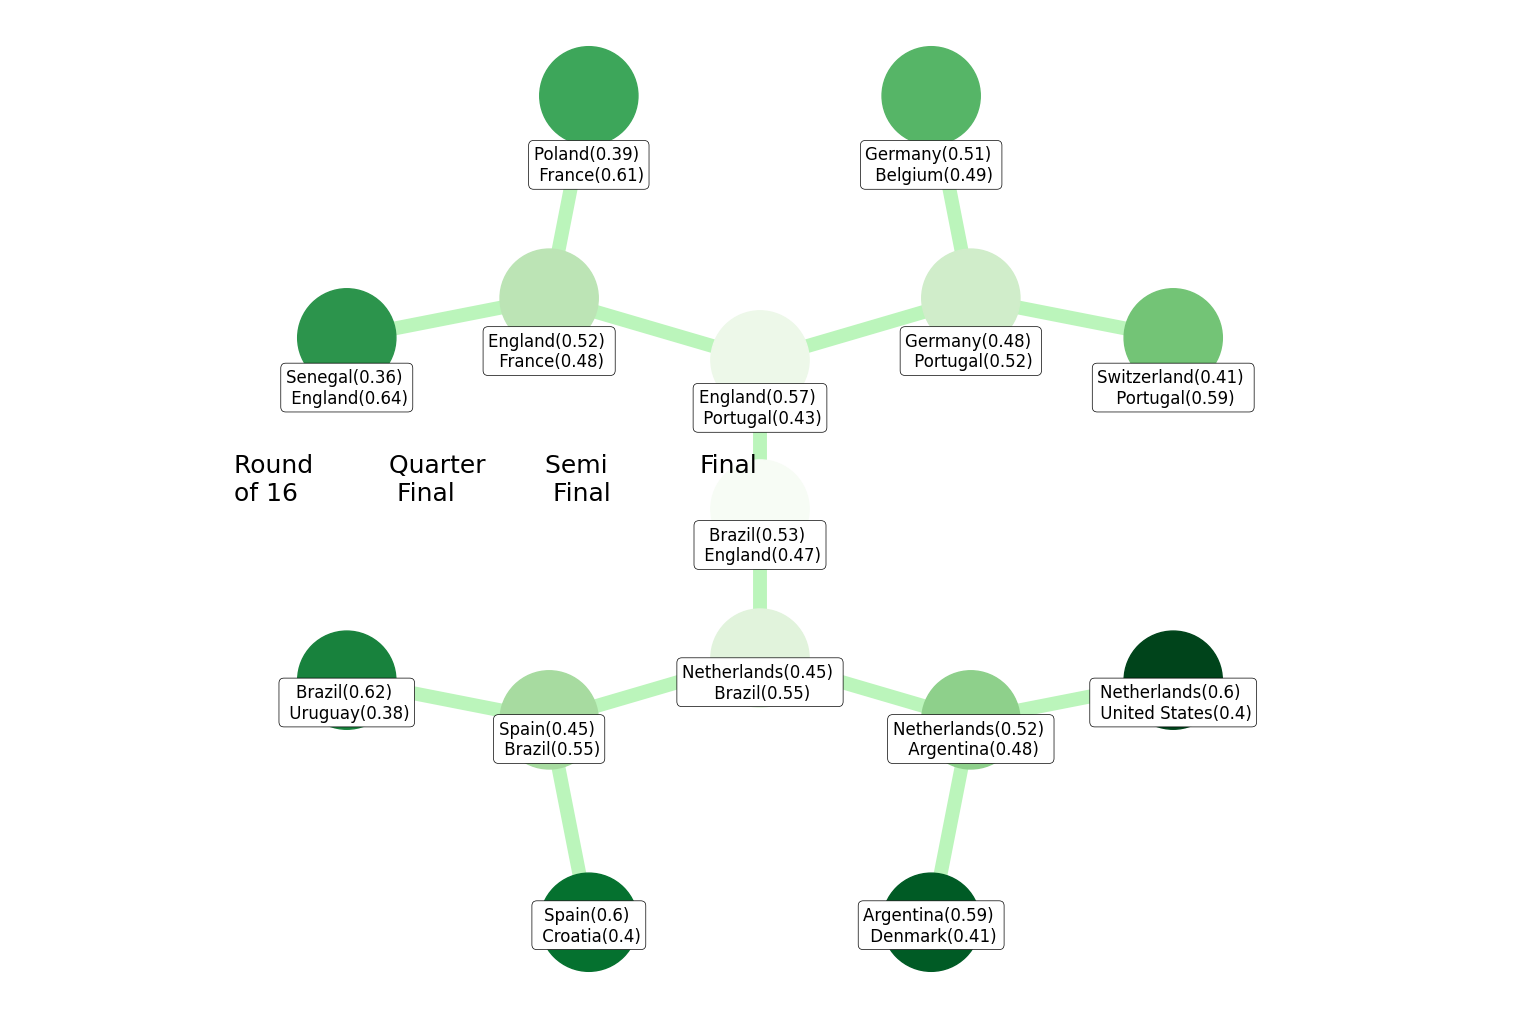

In [ ]:
plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)

labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')
labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()


nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 75
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()

Và đó là mô phỏng cuối cùng! Brazil đã giành được danh hiệu thứ 6! Hy vọng rằng dự đoán của tôi bây giờ là chính xác.

Thật tuyệt khi phân tích những khó khăn có thể xảy ra. Bỉ vượt qua Đức và bị Bồ Đào Nha đánh bại. Trận đấu giữa Argentina - Hà Lan rất chặt chẽ, Hà Lan có tỷ lệ chuyền bóng gần 1%. Điều tương tự cũng xảy ra giữa Pháp và Anh, với việc Anh vượt qua. Tôi nghĩ nước Anh lọt vào vòng chung kết là nỗi thất vọng lớn nhất của cuộc mô phỏng.

Cập nhật: cơ sở dữ liệu đã được cập nhật với các trận giao hữu cuối cùng mà các đội tuyển quốc gia thi đấu trước World Cup và cùng với đó, một số mô phỏng đã thay đổi. Pháp hiện đã đánh bại Anh ở tứ kết và họ bị Bồ Đào Nha đánh bại ở bán kết! Bồ Đào Nha vào chung kết là một bất ngờ lớn!

# **Kết Luận**

Mục tiêu của việc này là nâng cao kiến ​​​​thức của tôi với Machine Learning mô phỏng thứ gì đó mà tôi yêu thích (Fifa Football World Cup). Tôi nghĩ thật tuyệt vời khi tạo ra những mô hình mà chúng ta có thể thấy được kết quả trong đời thực và đó là điều sắp xảy ra!

Nói chung, tôi cho rằng mô hình dự đoán giống như cảm nhận chung của những người xem bóng đá. Không có bất ngờ lớn trong mô phỏng. Cũng thật thú vị khi xem các trận đấu với các đội ít được biết đến hơn ở vòng bảng, như Iran vs. Wales hoặc Senegal vs Ecuador. Tôi nghĩ rằng trong những trò chơi như vậy, mô hình này là một hướng dẫn tốt để đặt cược, vì kiến ​​thức của hầu hết mọi người về các đội tuyển quốc gia hạng hai là không tốt.